<h2 style='text-align: center;'>ID5004: AI in Predictive Maintenance, Reliability, and
Warranty
Assignment: Multivariate Statistics and Fault Detection</h2>

<h3 style='text-align: center;'>Author - Aloy Banerjee</h3>
<h3 style='text-align: center;'>Roll No. CH22M503</h3

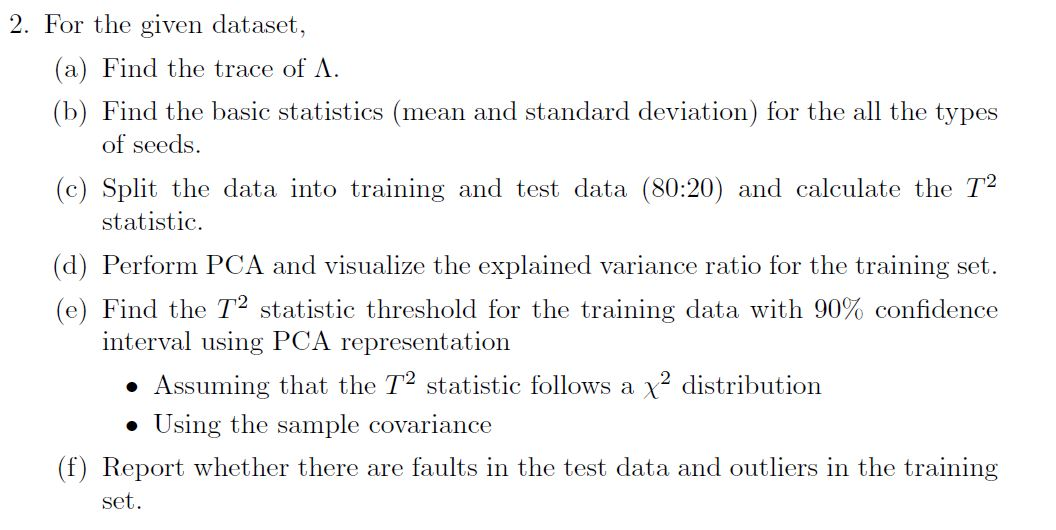

#### Importing Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib.patches import Ellipse
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import preprocessing
from sklearn.decomposition import PCA

from scipy.stats import f
from scipy.stats import chi2

from tsquared import HotellingT2

#### Common variable

In [2]:
scaler = StandardScaler()
dataset_whole = pd.read_csv('seeds.csv')
unique_type = np.unique(dataset_whole['Type'])
variance_consideration = 0.95
alpha_90 = 0.1  # 90% confidence level (10% significance level)
alpha_95 = 0.05  # 95% confidence level (5% significance level)
alpha_99 = 0.01  # 99% confidence level (1% significance level)

#### Common Functionality

In [3]:
def dataProcessing(dataset, scaler):
    """
    Preprocesses the dataset by dropping the 'Type' column, scaling the data, and returning both 
    the original and scaled datasets.

    Args:
        dataset (DataFrame): The input dataset.
        scaler (object): The scaler object for data scaling.

    Returns:
        dataset (DataFrame): The preprocessed original dataset.
        dataset_scale (ndarray): The scaled dataset.
    """
    # Drop the 'Type' column from the dataset
    dataset = dataset.drop('Type', axis=1)
    
    # Display descriptive statistics of the whole dataset
    display(dataset_whole.describe())
    
    # Display information about the dataset
    display(dataset_whole.info())
    
    # Fit the scaler on the dataset and transform the dataset
    scaler.fit(dataset)
    dataset_scale = scaler.transform(dataset)    
    
    # Print the scaled dataset
    print(dataset_scale)
    
    return dataset, dataset_scale    

def eigendecomposition(dataset, meanshifting):
    """
    Performs eigendecomposition on the dataset, optionally applying mean shifting.

    Args:
        dataset (ndarray): The input dataset.
        meanshifting (bool): Whether to apply mean shifting.

    Returns:
        covarince_mat (ndarray): The covariance matrix.
        eigenvalues (ndarray): The eigenvalues.
        eigenvectors (ndarray): The eigenvectors.
    """
    # Apply mean shifting if meanshifting is True
    if meanshifting:
        dataset_meaned = (dataset - np.mean(dataset, axis=0))
    else:
        dataset_meaned = dataset        
    
    # Calculate the length of the dataset
    length = len(dataset_meaned)
    
    # Calculate the covariance matrix
    covarince_mat = (1/(length-1)) * (dataset_meaned.T @ dataset_meaned)
    
    # Display the covariance matrix
    display(covarince_mat)
    
    # Perform eigendecomposition on the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eig(covarince_mat)
    
    # Print the shape of the covariance matrix, eigenvalues, and eigenvectors
    print("Covariance matrix shape:", covarince_mat.shape)
    print("Eigen Vector shape:", eigenvectors.shape)
    print("Eigen Value shape:", eigenvalues.shape)
    print("Eigen Vector:", eigenvectors)
    print("Eigen Value:", eigenvalues)
    
    return covarince_mat, eigenvalues, eigenvectors

def datasplitting(dataset, dataset_whole):
    """
    Splits the dataset into training and test sets.

    Args:
        dataset (DataFrame): The input dataset.
        dataset_whole (DataFrame): The complete dataset.

    Returns:
        X_train (DataFrame): The training features.
        X_test (DataFrame): The test features.
        y_train (Series): The training labels.
        y_test (Series): The test labels.
    """
    # Split the dataset into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(dataset, dataset_whole['Type'], test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test

def tsquaredStat(eigenvalues, eigenvectors, data, dataset_type):
    """
    Calculates the T-squared statistic for each data point.

    Args:
        eigenvalues (ndarray): The eigenvalues.
        eigenvectors (ndarray): The eigenvectors.
        data (DataFrame): The input data.
        dataset_type (str): The type of dataset.

    Returns:
        Lambda (ndarray): The diagonal matrix of eigenvalues.
        t_squared_values (list): The list of T-squared values.
        sum_t_squared_val (float): The sum of T-squared values.
    """
    # Sort the eigenvalues and eigenvectors in descending order
    eigenvalue_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues_sorted = eigenvalues[eigenvalue_indices]
    eigenvectors_sorted = eigenvectors[:, eigenvalue_indices]
    Lambda = np.diag(eigenvalues_sorted)
    Lambda_inv = np.linalg.inv(Lambda)
    t_squared_values = []
    data_array = np.array(data)
    sum_t_squared_val = 0
    for i in range(len(data_array)):
        data_loop = data_array[i, :].reshape(-1,1)
        t_squared = data_loop.T @ eigenvectors_sorted @ Lambda_inv @ eigenvectors_sorted.T @ data_loop
        sum_t_squared_val += t_squared
        t_squared_values.append(t_squared[0][0])
    
    # Print the dataset type
    print(f'{dataset_type} :')
    
    # Print the T-squared values
    print('T Squared Values : \n', t_squared_values)
    
    # Print the sum of T-squared values
    print('Sum of T Squared Values : ', sum_t_squared_val[0][0])
    
    return Lambda, t_squared_values, sum_t_squared_val[0][0]

def pc_required(explained_variances):
    '''
    Determine the explained variation in comparison to a predetermined threshold value, 
    and then provide the number of principle components to be chosen.
    '''   
    # Find the number of principal components that explain the desired variance threshold
    return np.argmax(np.cumsum(explained_variances) >= variance_consideration) + 1

def perform_PCA(input_data):
    """
    Performs Principal Component Analysis (PCA) on the input data.

    Args:
        input_data (ndarray): The input data.

    Returns:
        considerable_PC (int): The number of considerable principle components.
        input_data_transformed (ndarray): The transformed input data.
    """
    # Create a PCA object
    pca = PCA()

    # Fit the PCA model to the input data
    pca.fit(input_data)

    # Transform the input data using the PCA model
    input_data_transformed = pca.transform(input_data)

    # Obtain the explained variance ratio for each principal component
    explained_variance_ratio = pca.explained_variance_ratio_

    # Calculate the cumulative explained variance
    cumulative_variance = np.cumsum(explained_variance_ratio)

    # Get the total number of principal components
    num_components = len(explained_variance_ratio)

    # Determine the number of considerable principle components based on a threshold
    considerable_PC = pc_required(explained_variance_ratio)

    # Print the number of total components and the number of considerable principle components
    print(f'Number of total component : {num_components}')
    print('Considerable Principle Component : ', considerable_PC)

    # Create a scree plot to visualize the explained variance
    plt.figure(figsize=(8, 6))
    plt.plot(np.arange(1, num_components + 1), cumulative_variance, marker='o', linestyle='-', color='b')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Scree Plot')
    plt.grid(True)
    plt.xticks(np.arange(1, num_components + 1))
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Print the explained variance ratio for each principal component
    print("Explained Variance Ratio:")
    for i, ratio in enumerate(explained_variance_ratio):
        print(f"Principal Component {i+1}: {ratio:.4f}")

    # Print the cumulative explained variance for each principal component
    print("\nCumulative Explained Variance:")
    for i, var in enumerate(cumulative_variance):
        print(f"Principal Components 1-{i+1}: {var:.4f}")

    return considerable_PC, input_data_transformed

def statisticalAnalysis(inputdata, considerable_PC, transformed_data, alpha):
    """
    Performs statistical analysis on the transformed data.

    Args:
        inputdata (ndarray): The input data.
        considerable_PC (int): The number of considerable principle components.
        transformed_data (ndarray): The transformed data.
        alpha (float): The significance level.

    Returns:
        None
    """
    # Part 1 
    print('Assuming that the T2 statistic follows a χ2 distribution')
    # Calculate the T2 statistic threshold as per input alpha
    total_num_features = transformed_data.shape[1]
    print("Total Number of Features:", total_num_features)
    print('Considerable Principle Component : ', considerable_PC)
    
    # Degrees of freedom for the chi-square distribution
    dof = considerable_PC # number of Considerable Principle Component 
    print('Degree of Freedom', dof)

    # Calculate the T2 statistic threshold using the chi-square distribution    
    threshold = chi2.ppf(1 - alpha, df=dof)
    print("T2 Statistic Threshold:", threshold)


    # Part 2
    print('Using the sample covariance')
    # Calculating T2 statistic threshold when sample covariance is used
    dfn = considerable_PC  # Degrees of freedom numerator
    dfd = inputdata.shape[0] - considerable_PC  # Degrees of freedom denominator

    # Calculate the critical value of F-distribution
    critical_value = f.ppf(1 - alpha, dfn, dfd)
    print("Critical value F_alpha(a, n-a):", critical_value)

    # Calculating T^2 statistic threshold
    n = inputdata.shape[0] - considerable_PC
    a = considerable_PC
    T_2_alpha = ((a * (n - 1) * (n + 1)) / (n * (n - a))) * critical_value
    print("T2 Statistic Threshold:", T_2_alpha)   
    
def outlier_threshold(alpha, input_data, considerablePC):
    """
    This function calculates the threshold for identifying outliers based on Hotelling's T-square 
    distribution and the F-distribution. This is used in multivariate outlier detection.

    Args:
    
    alpha : float
        The significance level for the F-distribution. This is used to control the Type I error 
        rate, i.e., the probability of falsely identifying an observation as an outlier.

    input_data : array-like
        A 2-dimensional numpy array or pandas DataFrame containing the multivariate data. Each 
        row represents an observation and each column represents a variable.

    considerablePC : int
        The number of principal components to be considered for outlier detection. This should be 
        less than or equal to the number of variables (columns) in the input data.

    Returns:
    
    float
        The threshold for identifying outliers. Observations with a T-square value greater than 
        this threshold are identified as outliers.    
    """
    n = input_data.shape[0]
    a = considerablePC
    f_alpha = f.ppf(alpha, a, n - a - 1)
    threshold_outlier= ((n - 1) ** 2 * (a / (n - a - 1)) * f_alpha) / (n * (1 + (a / (n - a - 1))) * f_alpha)
    return threshold_outlier

    

#### Data Loading & Processing

In [4]:
dataset, dataset_scale = dataProcessing(dataset_whole, scaler)

,Area,Perimeter,Compactness,Kernel.Length,Kernel.Width,Asymmetry.Coeff,Kernel.Groove,Type
count,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000
mean,14.918744,14.595829,0.870811,5.643151,3.265533,3.699217,5.420653,1.994975
std,2.919976,1.310445,0.023320,0.443593,0.378322,1.471102,0.492718,0.813382
min,10.590000,12.410000,0.808100,4.899000,2.630000,0.765100,4.519000,1.000000
25%,12.330000,13.470000,0.857100,5.267000,2.954500,2.570000,5.046000,1.000000
50%,14.430000,14.370000,0.873400,5.541000,3.245000,3.631000,5.228000,2.000000
75%,17.455000,15.805000,0.886800,6.002000,3.564500,4.799000,5.879000,3.000000
max,21.180000,17.250000,0.918300,6.675000,4.033000,8.315000,6.550000,3.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             199 non-null    float64
 1   Perimeter        199 non-null    float64
 2   Compactness      199 non-null    float64
 3   Kernel.Length    199 non-null    float64
 4   Kernel.Width     199 non-null    float64
 5   Asymmetry.Coeff  199 non-null    float64
 6   Kernel.Groove    199 non-null    float64
 7   Type             199 non-null    int64  
dtypes: float64(7), int64(1)
memory usage: 12.6 KB


None

[[ 0.11716431  0.18679667  0.0081443  ...  0.12313474 -1.00737062
  -0.40826475]
 [-0.01330197 -0.01975993  0.44234139 ...  0.17878306 -1.82718718
  -0.9454197 ]
 [-0.21586804 -0.38697165  1.46979786 ...  0.18938275 -0.68162472
  -1.21196249]
 ...
 [-0.59010028 -0.71593216  0.75186803 ... -0.08885888  3.14554887
  -0.74195192]
 [-1.05703224 -1.06019315 -0.80436312 ... -1.13822732 -0.06897709
  -0.76636805]
 [-0.89909937 -0.96073998 -0.10362921 ... -0.77253832  1.32055406
  -0.72770917]]


## a) Find the trace of Λ.

#### a) Without Scalling

In [5]:
covarince_mat, eigenvalues, eigenvectors = eigendecomposition(dataset, True)

,Area,Perimeter,Compactness,Kernel.Length,Kernel.Width,Asymmetry.Coeff,Kernel.Groove
Area,8.526259,3.805181,0.041530,1.231976,1.072631,-0.957144,1.241226
Perimeter,3.805181,1.717265,0.016253,0.565577,0.468748,-0.406831,0.574360
Compactness,0.041530,0.016253,0.000544,0.003869,0.006724,-0.011300,0.002608
Kernel.Length,1.231976,0.565577,0.003869,0.196775,0.144776,-0.110744,0.203731
Kernel.Width,1.072631,0.468748,0.006724,0.144776,0.143127,-0.140875,0.139474
Asymmetry.Coeff,-0.957144,-0.406831,-0.011300,-0.110744,-0.140875,2.164142,-0.002428
Kernel.Groove,1.241226,0.574360,0.002608,0.203731,0.139474,-0.002428,0.242771


Covariance matrix shape: (7, 7)
Eigen Vector shape: (7, 7)
Eigen Value shape: (7,)
Eigen Vector: [[-8.85169308e-01  9.36176492e-02 -2.62533402e-01 -2.03441900e-01
  -1.39443945e-01  2.78046562e-01 -2.53797953e-02]
 [-3.95839443e-01  5.31524997e-02  2.77882551e-01  5.88392440e-01
   5.72123257e-01 -2.92226998e-01  6.58781574e-02]
 [-4.25074480e-03 -2.98177972e-03 -5.78406038e-02 -5.81051325e-02
  -5.23641346e-02 -4.51665532e-02  9.94217923e-01]
 [-1.28578012e-01  2.85084775e-02  3.96668448e-01  4.29298306e-01
  -7.90540121e-01 -1.26721311e-01  3.08701969e-04]
 [-1.10984612e-01  8.07419729e-04 -3.16823362e-01 -2.39176432e-01
  -1.26755669e-01 -8.98649492e-01 -8.03831249e-02]
 [ 1.19540898e-01  9.90285180e-01 -6.58865305e-02  2.62037581e-02
  -2.99359809e-03  2.70061672e-03  1.14444388e-03]
 [-1.28951338e-01  8.32077767e-02  7.67103664e-01 -6.05673579e-01
   9.72559443e-02 -1.07782095e-01  9.15447308e-03]]
Eigen Value: [1.08516254e+01 2.04834826e+00 7.37914840e-02 1.27479228e-02
 2.756007

In [6]:
trace = np.trace(np.diag(eigenvalues))
print("Trace of Λ without scailling:", trace)

Trace of Λ without scailling: 12.990882469802049


#### a) With scalling

In [7]:
covarince_mat_scale, eigenvalues_scale, eigenvectors_scale = eigendecomposition(dataset_scale, True)

array([[ 1.00505051,  0.99945967,  0.61296771,  0.95592951,  0.97588352,
        -0.22394581,  0.86708441],
       [ 0.99945967,  1.00505051,  0.5345268 ,  0.97785806,  0.95027092,
        -0.21210008,  0.89403606],
       [ 0.61296771,  0.5345268 ,  1.00505051,  0.3759002 ,  0.7660163 ,
        -0.33106381,  0.22816301],
       [ 0.95592951,  0.97785806,  0.3759002 ,  1.00505051,  0.8670369 ,
        -0.17056152,  0.9368318 ],
       [ 0.97588352,  0.95027092,  0.7660163 ,  0.8670369 ,  1.00505051,
        -0.25440081,  0.75200687],
       [-0.22394581, -0.21210008, -0.33106381, -0.17056152, -0.25440081,
         1.00505051, -0.00336631],
       [ 0.86708441,  0.89403606,  0.22816301,  0.9368318 ,  0.75200687,
        -0.00336631,  1.00505051]])

Covariance matrix shape: (7, 7)
Eigen Vector shape: (7, 7)
Eigen Value shape: (7,)
Eigen Vector: [[ 0.44444526  0.0268951  -0.02541939  0.19763627  0.19751625 -0.73412145
  -0.42905925]
 [ 0.44156742  0.08298812  0.06019769  0.30034829  0.16637062  0.67153918
  -0.47503082]
 [ 0.27791499 -0.52535969 -0.63238211 -0.34000075 -0.32627308  0.07310414
  -0.13947927]
 [ 0.42412605  0.200075    0.21443932  0.25098045 -0.76832639 -0.0463691
   0.28042137]
 [ 0.43293659 -0.11572453 -0.2151238   0.20373132  0.46870015  0.03700686
   0.70024261]
 [-0.1157433   0.72122562 -0.67513087  0.09326364 -0.04045161  0.00383945
  -0.01691821]
 [ 0.38669933  0.37788656  0.21853787 -0.80120818  0.12333864  0.0349609
   0.03920887]]
Eigen Value: [5.05691778e+00 1.20519035e+00 6.79631565e-01 6.85475795e-02
 1.89074688e-02 8.16380060e-04 5.34241202e-03]


In [8]:
trace_scale = np.trace(np.diag(eigenvalues_scale))
print("Trace of Λ with scalling:", trace_scale)

Trace of Λ with scalling: 7.035353535353538


## b) Find the basic statistics (mean and standard deviation) for the all the types of seeds.

In [9]:
unique_type

array([1, 2, 3], dtype=int64)

In [10]:
# Group the data by seed type
grouped_data = dataset_whole.groupby('Type')
print(grouped_data)
df_groupdata_stats = grouped_data.describe()
display(grouped_data.describe())
df_groupdata_stats.to_csv('groupwiseStat.csv', sep=',', index=False, encoding='utf-8')

Area                                                            \
     count       mean       std    min    25%    50%      75%    max   
Type                                                                   
1     66.0  14.354394  1.178117  11.23  13.75  14.36  15.0450  17.08   
2     68.0  18.370147  1.413670  15.38  17.35  18.72  19.1425  21.18   
3     65.0  11.881077  0.720822  10.59  11.27  11.84  12.3800  13.37   

     Perimeter             ... Asymmetry.Coeff        Kernel.Groove            \
         count       mean  ...             75%    max         count      mean   
Type                       ...                                                  
1         66.0  14.306818  ...         3.36175  6.685          66.0  5.087197   
2         68.0  16.156912  ...         4.45375  6.682          68.0  6.026515   
3         65.0  13.256154  ...         5.46200  8.315          65.0  5.125415   

                                                       
           std    min     25%     50%      75%    max  
Type                                                   
1     0.259822  4.519  4.9245  5.0940  5.22150  5.877  
2     0.246663  5.144  5.8785  5.9815  6.18725  6.550  
3     0.160033  4.794  5.0030  5.1320  5.26300  5.491  

[3 rows x 56 columns]

## c) Split the data into training and test data (80:20) and calculate the T2 statistic.

<h3 style='text-align: center;'> Formulation  $T^{2} = x^{T}V \Lambda^{-1}V^{T}x$</h3>

#### c) Without scalling

In [11]:
X_train, X_test, y_train, y_test = datasplitting(dataset, dataset_whole)

In [12]:
print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Training data shape: (159, 7)
Test data shape: (40, 7)


In [13]:
covarince_mat, eigenvalues, eigenvectors = eigendecomposition(X_train, True)

,Area,Perimeter,Compactness,Kernel.Length,Kernel.Width,Asymmetry.Coeff,Kernel.Groove
Area,8.188433,3.665289,0.039586,1.194170,1.023302,-1.029723,1.195387
Perimeter,3.665289,1.658353,0.015580,0.548513,0.448883,-0.443532,0.554551
Compactness,0.039586,0.015580,0.000518,0.003850,0.006353,-0.011959,0.002381
Kernel.Length,1.194170,0.548513,0.003850,0.190849,0.140082,-0.121974,0.197734
Kernel.Width,1.023302,0.448883,0.006353,0.140082,0.135620,-0.151553,0.132816
Asymmetry.Coeff,-1.029723,-0.443532,-0.011959,-0.121974,-0.151553,2.304619,0.002220
Kernel.Groove,1.195387,0.554551,0.002381,0.197734,0.132816,0.002220,0.239767


Covariance matrix shape: (7, 7)
Eigen Vector shape: (7, 7)
Eigen Value shape: (7,)
Eigen Vector: [[-8.82726967e-01  1.09229598e-01 -2.57148819e-01 -2.18747177e-01
  -1.20496555e-01  2.82075925e-01 -2.82826364e-02]
 [-3.95881226e-01  5.83155736e-02  2.56814649e-01  6.13207757e-01
   5.43276423e-01 -3.12610580e-01  7.08885363e-02]
 [-4.22717175e-03 -2.88755892e-03 -5.54901436e-02 -6.39634267e-02
  -5.48010095e-02 -3.60216146e-02  9.94234685e-01]
 [-1.29290347e-01  3.03925327e-02  3.67623220e-01  4.28306213e-01
  -8.09185438e-01 -9.47945323e-02 -4.24653102e-04]
 [-1.10031383e-01  2.14061903e-03 -3.05358569e-01 -2.56241540e-01
  -1.51855718e-01 -8.94613856e-01 -7.47717832e-02]
 [ 1.36793052e-01  9.87811262e-01 -6.93223276e-02  2.64497756e-02
  -2.47729957e-03  1.94366498e-03  1.21699510e-03]
 [-1.28522568e-01  8.92214834e-02  7.94761154e-01 -5.67652243e-01
   9.73693446e-02 -1.09938656e-01  8.93405133e-03]]
Eigen Value: [1.04684919e+01 2.16072554e+00 7.22624332e-02 1.22840220e-02
 2.791471

In [14]:
Lambda_train, t_squared_values_train, sum_t_squared_values_train = tsquaredStat(eigenvalues, eigenvectors, X_train, 'Train Dataset')

Train Dataset :
T Squared Values : 
 [69894.2980631995, 70274.18339492616, 69766.67956103581, 70090.2768098407, 69847.50995386558, 69857.9991154946, 70119.59235978406, 69522.39276631371, 70965.32649611626, 69545.93507627086, 69895.14089584474, 69967.38454263029, 69795.70978586549, 69414.22247555622, 70116.10249816888, 69282.42467382168, 69593.8837409782, 69342.94794833021, 70498.14869293329, 68694.66071998137, 69124.52982971093, 70187.42521090388, 69833.44263935632, 69804.25807078776, 68851.4348350354, 70115.47397476142, 68931.29821236123, 70545.79699292278, 70752.01808960513, 70387.01502950632, 69459.35412560166, 69945.24753215228, 70548.44559387658, 68968.49781579323, 68360.53020593166, 69489.43059678763, 70546.998480236, 69709.66783833687, 68712.7065667325, 69962.25333328235, 69465.2405614744, 70065.93888736622, 69367.70923934894, 69614.58457006805, 69496.15937593131, 70337.82335136281, 69362.7473029274, 69335.29712318275, 69313.95332118354, 69072.45577144528, 70193.15393094477, 698

#### Using inbuilt library - without scalling

In [47]:
#Using inbuilt library
clf = HotellingT2()
# Hotelling's T2 without dataset cleaning.
clf.fit(X_train)
train_scores = clf.score_samples(X_train)
print(f"\nT2 Statistics: {train_scores}")


T2 Statistics: [ 9.20670525  4.41231858  5.04357688  3.07609455  1.45484681  8.44101252
  4.09760412  5.46926895  7.80615417  6.05723196  3.11357891  2.97873796
  5.1437081   6.27484444 13.99104358  7.49117401  3.77331298  6.60653898
 18.02025748  8.11899318  8.89878372 10.51290689  5.05747599  4.08888223
 12.96869851  5.98657603 14.99020383  5.66355799 10.32578109  3.45195012
  4.34538468  4.00622728 10.483485    7.13191566 14.69009929  4.85801982
  6.24901742  8.43019164 12.18589162  5.41060125 10.09944309  2.16707003
  5.07775544  2.88648341  4.23524077  2.39051938  5.10960759  7.98542957
  7.46960024  8.92464304  3.14192275 10.7013703   2.2713631   6.59173288
  2.13989746  3.5556654   3.86507774  4.46085357  5.62103977  3.15871399
  3.77144766  3.16280059 14.80506331  2.55117927  5.30615336 15.51022649
  7.96455013  4.07200106  6.32460785  8.75937472  2.88473248 18.79965709
  3.9272825   4.54293536  5.61970407  2.3362702   5.4917328   7.77928089
  5.80296958  4.84786429  4.9108797

#### c) With scalling

In [16]:
X_train_scale, X_test_scale, y_train_scale, y_test_scale = datasplitting(dataset_scale, dataset_whole)

In [17]:
print("Scaled Training data shape:", X_train_scale.shape)
print("Scaled Test data shape:", X_test_scale.shape)

Scaled Training data shape: (159, 7)
Scaled Test data shape: (40, 7)


In [18]:
covarince_mat_scale, eigenvalues_scale, eigenvectors_scale = eigendecomposition(X_train_scale, True)

array([[ 0.96522861,  0.96271607,  0.58427549,  0.9265943 ,  0.93100366,
        -0.24092733,  0.83506223],
       [ 0.96271607,  0.97057182,  0.51239517,  0.9483553 ,  0.91000023,
        -0.23123405,  0.86320165],
       [ 0.58427549,  0.51239517,  0.95764955,  0.37407854,  0.72375962,
        -0.3503593 ,  0.20830859],
       [ 0.9265943 ,  0.9483553 ,  0.37407854,  0.97477982,  0.83892463,
        -0.18785626,  0.90925624],
       [ 0.93100366,  0.91000023,  0.72375962,  0.83892463,  0.95233318,
        -0.27368368,  0.71610943],
       [-0.24092733, -0.23123405, -0.3503593 , -0.18785626, -0.27368368,
         1.07028966,  0.00307841],
       [ 0.83506223,  0.86320165,  0.20830859,  0.90925624,  0.71610943,
         0.00307841,  0.99261664]])

Covariance matrix shape: (7, 7)
Eigen Vector shape: (7, 7)
Eigen Value shape: (7,)
Eigen Vector: [[ 0.44304849  0.03212855 -0.02887574  0.20445538  0.18504085 -0.73655009
  -0.42812829]
 [ 0.44149753  0.07897768  0.06094722  0.30489966  0.1510445   0.66902859
  -0.48140461]
 [ 0.27564393 -0.46886513 -0.67563368 -0.36436117 -0.3026779   0.07273362
  -0.13432011]
 [ 0.42694661  0.17890281  0.21105081  0.23043996 -0.77592834 -0.04321953
   0.29005627]
 [ 0.4287223  -0.09538415 -0.22416183  0.22025079  0.47532474  0.04001676
   0.69340116]
 [-0.13163545  0.7678795  -0.61760568  0.09827024 -0.04057696  0.00510547
  -0.01633427]
 [ 0.38651556  0.37703115  0.25048557 -0.78816566  0.14726388  0.03330465
   0.04134325]]
Eigen Value: [4.88199227e+00 1.24209528e+00 6.62178547e-01 7.20253409e-02
 1.88137033e-02 7.71128300e-04 5.59301263e-03]


In [19]:
Lambda_train_scale, t_squared_values_train_scale, sum_t_squared_values_train_scale = tsquaredStat(eigenvalues_scale, eigenvectors_scale, X_train_scale, 'Scale Train Dataset')

Scale Train Dataset :
T Squared Values : 
 [9.315790640611748, 4.480035246676832, 5.310530525497461, 3.1276217271152893, 1.575602667366586, 8.899128272292126, 4.428089478739972, 5.588213211567905, 8.036849816175561, 5.694781018250479, 3.2023986294214035, 2.9808329164533425, 4.874942802843073, 6.30281085714919, 14.0936809118405, 7.473304255647594, 3.589560387790534, 6.724188177754785, 17.775281581165228, 8.363984248005325, 8.896097633788125, 10.819300732916616, 5.405528371370936, 4.0302518239930585, 12.352535068221375, 6.06619223844958, 14.77886010017735, 5.4820366790201955, 10.457853670858707, 3.5525773639855833, 4.237073444162433, 4.304248327662728, 10.84906112645539, 7.025260218673901, 14.420330987805295, 5.245407012550411, 6.153766821549662, 7.9576328809409915, 12.32425589258417, 5.359528437506881, 9.468692123816302, 2.2176118041648505, 4.773895212533692, 3.0241667569416757, 4.258923939627213, 2.6291075502890764, 5.350573326834871, 7.92484096268733, 7.422776207003822, 8.303846959286

#### Using inbuilt library - with scalling

In [53]:
clf_scale = HotellingT2()

# Hotelling's T2 without dataset cleaning.
clf_scale.fit(X_train_scale)
train_scores_scale = clf_scale.score_samples(X_train_scale)
print(train_scores_scale)

[ 9.20670525  4.41231858  5.04357688  3.07609455  1.45484681  8.44101252
  4.09760412  5.46926895  7.80615417  6.05723196  3.11357891  2.97873796
  5.1437081   6.27484444 13.99104358  7.49117401  3.77331298  6.60653898
 18.02025748  8.11899318  8.89878372 10.51290689  5.05747599  4.08888223
 12.96869851  5.98657603 14.99020383  5.66355799 10.32578109  3.45195012
  4.34538468  4.00622728 10.483485    7.13191566 14.69009929  4.85801982
  6.24901742  8.43019164 12.18589162  5.41060125 10.09944309  2.16707003
  5.07775544  2.88648341  4.23524077  2.39051938  5.10960759  7.98542957
  7.46960024  8.92464304  3.14192275 10.7013703   2.2713631   6.59173288
  2.13989746  3.5556654   3.86507774  4.46085357  5.62103977  3.15871399
  3.77144766  3.16280059 14.80506331  2.55117927  5.30615336 15.51022649
  7.96455013  4.07200106  6.32460785  8.75937472  2.88473248 18.79965709
  3.9272825   4.54293536  5.61970407  2.3362702   5.4917328   7.77928089
  5.80296958  4.84786429  4.91087978 12.75674712  5

## d)  Perform PCA and visualize the explained variance ratio for the training set.

#### d) Without scalling

Number of total component : 7
Considerable Principle Component :  2


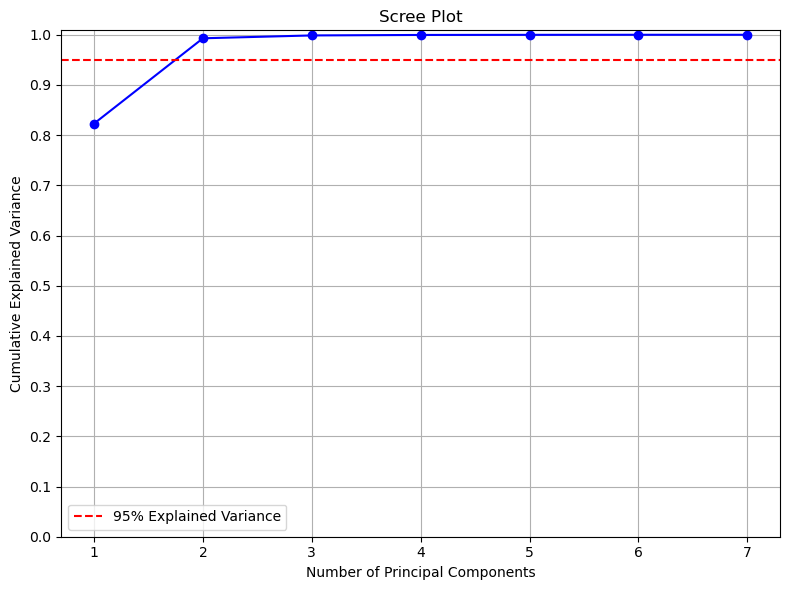

Explained Variance Ratio:
Principal Component 1: 0.8231
Principal Component 2: 0.1699
Principal Component 3: 0.0057
Principal Component 4: 0.0010
Principal Component 5: 0.0002
Principal Component 6: 0.0001
Principal Component 7: 0.0000

Cumulative Explained Variance:
Principal Components 1-1: 0.8231
Principal Components 1-2: 0.9930
Principal Components 1-3: 0.9987
Principal Components 1-4: 0.9997
Principal Components 1-5: 0.9999
Principal Components 1-6: 1.0000
Principal Components 1-7: 1.0000


(2,
 array([[-3.28437852e+00, -5.04361453e-01, -5.75161612e-02, ...,
         -5.19730718e-02, -8.28373104e-03, -3.89156435e-03],
        [-1.28727484e+00, -1.26015390e+00,  3.51945428e-02, ...,
         -1.32907744e-03, -6.05999389e-03, -6.96463449e-03],
        [ 1.90934978e+00, -2.53095266e+00,  6.34494150e-02, ...,
         -2.47965555e-02,  3.14973561e-02, -1.77490776e-03],
        ...,
        [ 5.10558459e+00,  5.35208274e-01, -1.31134960e-01, ...,
         -9.53798344e-03, -2.88467224e-02,  6.32850920e-03],
        [-4.50834638e+00,  3.27605816e+00,  2.14968622e-01, ...,
         -5.43371233e-02,  2.34710587e-02, -9.34443458e-04],
        [ 3.19105719e+00,  5.38407887e-01, -7.05973214e-02, ...,
          5.08495626e-02,  1.24151399e-03, -3.36600906e-03]]))

In [21]:
perform_PCA(X_train)

#### d) With scalling

Number of total component : 7
Considerable Principle Component :  3


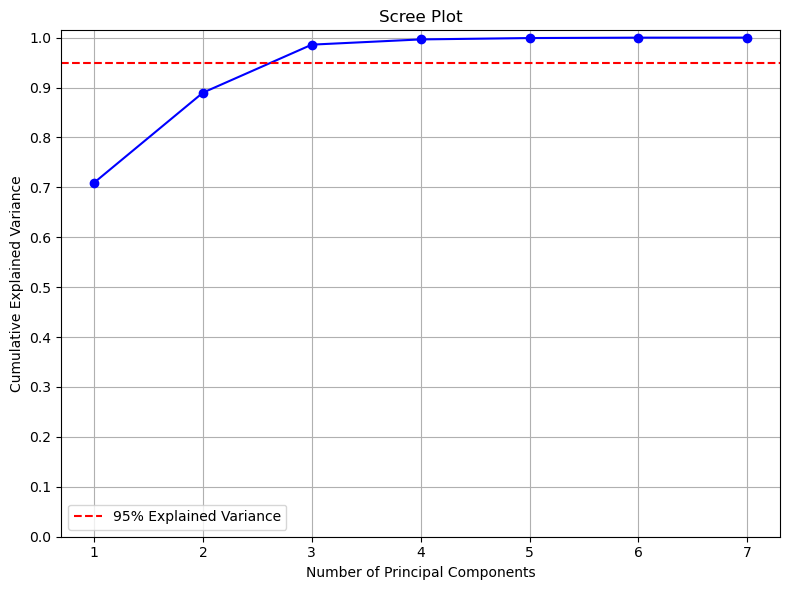

Explained Variance Ratio:
Principal Component 1: 0.7092
Principal Component 2: 0.1804
Principal Component 3: 0.0962
Principal Component 4: 0.0105
Principal Component 5: 0.0027
Principal Component 6: 0.0008
Principal Component 7: 0.0001

Cumulative Explained Variance:
Principal Components 1-1: 0.7092
Principal Components 1-2: 0.8897
Principal Components 1-3: 0.9859
Principal Components 1-4: 0.9963
Principal Components 1-5: 0.9991
Principal Components 1-6: 0.9999
Principal Components 1-7: 1.0000


(3,
 array([[-1.85568610e+00,  6.76315069e-01,  4.89911533e-01, ...,
         -5.73563714e-02,  4.44061136e-02,  1.14622539e-02],
        [-6.65438480e-01,  1.21814778e+00,  2.57533530e-01, ...,
         -3.56156511e-02, -2.09204952e-02, -1.48341086e-02],
        [ 1.17560536e+00,  1.71857122e+00, -6.89608873e-01, ...,
         -1.18748977e-01, -4.57420190e-02,  8.08183145e-03],
        ...,
        [ 3.52627004e+00, -6.39006342e-01, -2.26475855e-01, ...,
          9.58756629e-02,  8.60746293e-02,  1.21212686e-02],
        [-2.94012897e+00, -1.64638288e+00,  1.59318172e+00, ...,
         -1.11469185e-01, -9.63753690e-04,  2.28245891e-02],
        [ 2.17271418e+00, -4.46219774e-01,  2.45882677e-02, ...,
          6.58457843e-02, -5.58497739e-02, -1.93511764e-02]]))

In [22]:
perform_PCA(X_train_scale)

### e)  Find the T2 statistic threshold for the training data with 90% confidence interval using PCA representation
- Assuming that the T2 statistic follows a χ2 distribution
- Using the sample covariance

#### e) Without scalling

Number of total component : 7
Considerable Principle Component :  2


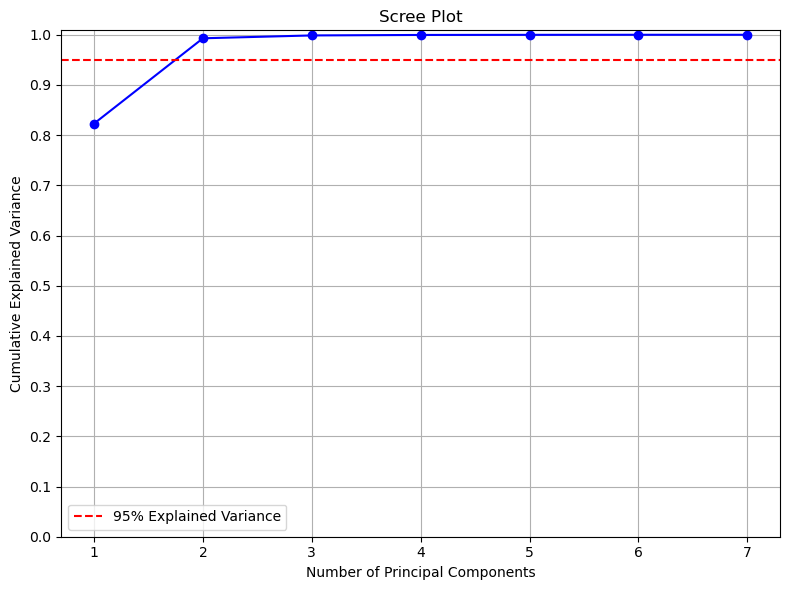

Explained Variance Ratio:
Principal Component 1: 0.8231
Principal Component 2: 0.1699
Principal Component 3: 0.0057
Principal Component 4: 0.0010
Principal Component 5: 0.0002
Principal Component 6: 0.0001
Principal Component 7: 0.0000

Cumulative Explained Variance:
Principal Components 1-1: 0.8231
Principal Components 1-2: 0.9930
Principal Components 1-3: 0.9987
Principal Components 1-4: 0.9997
Principal Components 1-5: 0.9999
Principal Components 1-6: 1.0000
Principal Components 1-7: 1.0000


In [23]:
considerable_PC, transformed_data = perform_PCA(X_train)

In [24]:
print('Result with scalled data : ')
statisticalAnalysis(X_train, considerable_PC, transformed_data, alpha_90)   

Result with scalled data : 
Assuming that the T2 statistic follows a χ2 distribution
Total Number of Features: 7
Considerable Principle Component :  2
Degree of Freedom 2
T2 Statistic Threshold: 4.605170185988092
Using the sample covariance
Critical value F_alpha(a, n-a): 2.3366877645565762
T2 Statistic Threshold: 4.733485105468707


#### e) With scalling

Number of total component : 7
Considerable Principle Component :  3


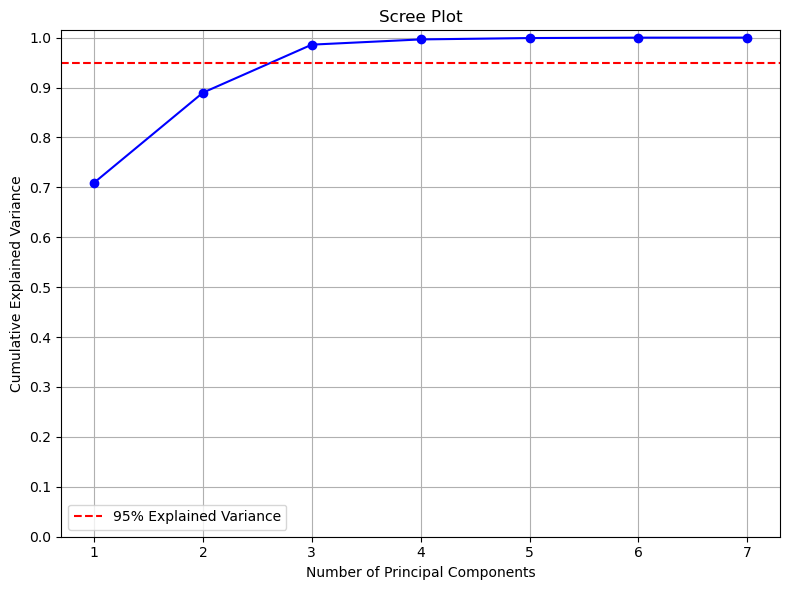

Explained Variance Ratio:
Principal Component 1: 0.7092
Principal Component 2: 0.1804
Principal Component 3: 0.0962
Principal Component 4: 0.0105
Principal Component 5: 0.0027
Principal Component 6: 0.0008
Principal Component 7: 0.0001

Cumulative Explained Variance:
Principal Components 1-1: 0.7092
Principal Components 1-2: 0.8897
Principal Components 1-3: 0.9859
Principal Components 1-4: 0.9963
Principal Components 1-5: 0.9991
Principal Components 1-6: 0.9999
Principal Components 1-7: 1.0000


In [25]:
considerable_PC_scale, transformed_data_scale = perform_PCA(X_train_scale)

In [26]:
print('Result with scalled data : ')
statisticalAnalysis(X_train_scale, considerable_PC_scale, transformed_data_scale, alpha_90) 

Result with scalled data : 
Assuming that the T2 statistic follows a χ2 distribution
Total Number of Features: 7
Considerable Principle Component :  3
Degree of Freedom 3
T2 Statistic Threshold: 6.251388631170325
Using the sample covariance
Critical value F_alpha(a, n-a): 2.1192236622197966
T2 Statistic Threshold: 6.482064834102407


### f) Report whether there are faults in the test data and outliers in the training set.

### Outlier

#### Outlier Calculation - Without scalling

Number of total component : 7
Considerable Principle Component :  2


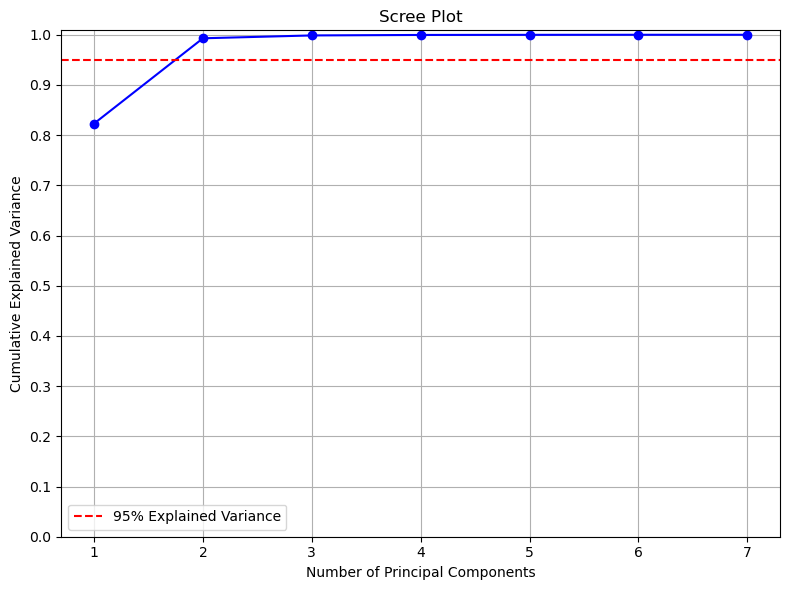

Explained Variance Ratio:
Principal Component 1: 0.8231
Principal Component 2: 0.1699
Principal Component 3: 0.0057
Principal Component 4: 0.0010
Principal Component 5: 0.0002
Principal Component 6: 0.0001
Principal Component 7: 0.0000

Cumulative Explained Variance:
Principal Components 1-1: 0.8231
Principal Components 1-2: 0.9930
Principal Components 1-3: 0.9987
Principal Components 1-4: 0.9997
Principal Components 1-5: 0.9999
Principal Components 1-6: 1.0000
Principal Components 1-7: 1.0000


In [27]:
considerable_PC, transformed_data = perform_PCA(X_train)

In [28]:
threshold = outlier_threshold(alpha_90, X_train, considerable_PC)
print(f'Threshold for outlier identification: {threshold}')

threshold_chi = chi2.ppf(1 - alpha_90, df=considerable_PC)
print(f'Threshold for outlier identification: {threshold_chi}')

Threshold for outlier identification: 1.987421383647799
Threshold for outlier identification: 4.605170185988092


In [29]:
covarince_mat, eigenvalues, eigenvectors = eigendecomposition(dataset, True)

,Area,Perimeter,Compactness,Kernel.Length,Kernel.Width,Asymmetry.Coeff,Kernel.Groove
Area,8.526259,3.805181,0.041530,1.231976,1.072631,-0.957144,1.241226
Perimeter,3.805181,1.717265,0.016253,0.565577,0.468748,-0.406831,0.574360
Compactness,0.041530,0.016253,0.000544,0.003869,0.006724,-0.011300,0.002608
Kernel.Length,1.231976,0.565577,0.003869,0.196775,0.144776,-0.110744,0.203731
Kernel.Width,1.072631,0.468748,0.006724,0.144776,0.143127,-0.140875,0.139474
Asymmetry.Coeff,-0.957144,-0.406831,-0.011300,-0.110744,-0.140875,2.164142,-0.002428
Kernel.Groove,1.241226,0.574360,0.002608,0.203731,0.139474,-0.002428,0.242771


Covariance matrix shape: (7, 7)
Eigen Vector shape: (7, 7)
Eigen Value shape: (7,)
Eigen Vector: [[-8.85169308e-01  9.36176492e-02 -2.62533402e-01 -2.03441900e-01
  -1.39443945e-01  2.78046562e-01 -2.53797953e-02]
 [-3.95839443e-01  5.31524997e-02  2.77882551e-01  5.88392440e-01
   5.72123257e-01 -2.92226998e-01  6.58781574e-02]
 [-4.25074480e-03 -2.98177972e-03 -5.78406038e-02 -5.81051325e-02
  -5.23641346e-02 -4.51665532e-02  9.94217923e-01]
 [-1.28578012e-01  2.85084775e-02  3.96668448e-01  4.29298306e-01
  -7.90540121e-01 -1.26721311e-01  3.08701969e-04]
 [-1.10984612e-01  8.07419729e-04 -3.16823362e-01 -2.39176432e-01
  -1.26755669e-01 -8.98649492e-01 -8.03831249e-02]
 [ 1.19540898e-01  9.90285180e-01 -6.58865305e-02  2.62037581e-02
  -2.99359809e-03  2.70061672e-03  1.14444388e-03]
 [-1.28951338e-01  8.32077767e-02  7.67103664e-01 -6.05673579e-01
   9.72559443e-02 -1.07782095e-01  9.15447308e-03]]
Eigen Value: [1.08516254e+01 2.04834826e+00 7.37914840e-02 1.27479228e-02
 2.756007

In [43]:
print(f'Lambda Train : {Lambda_train}')
print(f'T Squared Value : {t_squared_values_train}')
print(f'Sum of T Squared value : {sum_t_squared_values_train}')

Lambda Train : [[1.04684919e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.16072554e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 7.22624332e-02 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.22840220e-02
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  2.79147153e-03 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.57407537e-03 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 3.02535117e-05]]
T Squared Value : [69894.2980631995, 70274.18339492616, 69766.67956103581, 70090.2768098407, 69847.50995386558, 69857.9991154946, 70119.59235978406, 69522.39276631371, 70965.32649611626, 69545.93507627086, 69895.14

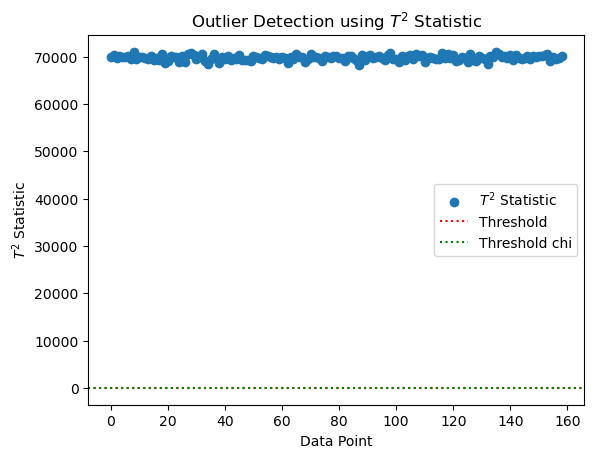

In [31]:
# Create a scatter plot of the T^2 statistic values
plt.scatter(range(len(t_squared_values_train)), t_squared_values_train, label='$T^2$ Statistic')

# Plot the threshold as a dotted line
plt.axhline(y=threshold, linestyle='dotted', color='red', label='Threshold')

plt.axhline(y=threshold_chi, linestyle='dotted', color='green', label='Threshold chi')

# Add labels and title to the plot
plt.xlabel('Data Point')
plt.ylabel('$T^2$ Statistic')
plt.title('Outlier Detection using $T^2$ Statistic')

# Add a legend
plt.legend()

# Show the plot
plt.show()

#### Outlier Calculation - With scalling

Number of total component : 7
Considerable Principle Component :  3


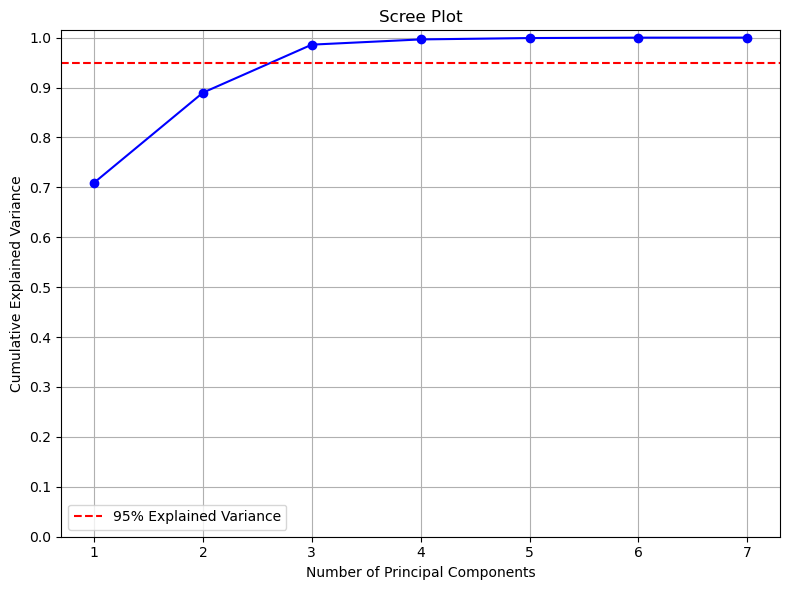

Explained Variance Ratio:
Principal Component 1: 0.7092
Principal Component 2: 0.1804
Principal Component 3: 0.0962
Principal Component 4: 0.0105
Principal Component 5: 0.0027
Principal Component 6: 0.0008
Principal Component 7: 0.0001

Cumulative Explained Variance:
Principal Components 1-1: 0.7092
Principal Components 1-2: 0.8897
Principal Components 1-3: 0.9859
Principal Components 1-4: 0.9963
Principal Components 1-5: 0.9991
Principal Components 1-6: 0.9999
Principal Components 1-7: 1.0000


In [32]:
considerable_PC_scale, transformed_data_scale = perform_PCA(X_train_scale)

In [33]:
threshold_scale = outlier_threshold(alpha_90, X_train_scale, considerable_PC_scale)
print(f'Threshold for outlier identification: {threshold_scale}')

threshold_chi_scale = chi2.ppf(1 - alpha_90, df=considerable_PC)
print(f'Threshold for outlier identification: {threshold_chi_scale}')

Threshold for outlier identification: 2.9811320754716983
Threshold for outlier identification: 4.605170185988092


In [50]:
covarince_mat_scale, eigenvalues_scale, eigenvectors_scale = eigendecomposition(dataset, True)

,Area,Perimeter,Compactness,Kernel.Length,Kernel.Width,Asymmetry.Coeff,Kernel.Groove
Area,8.526259,3.805181,0.041530,1.231976,1.072631,-0.957144,1.241226
Perimeter,3.805181,1.717265,0.016253,0.565577,0.468748,-0.406831,0.574360
Compactness,0.041530,0.016253,0.000544,0.003869,0.006724,-0.011300,0.002608
Kernel.Length,1.231976,0.565577,0.003869,0.196775,0.144776,-0.110744,0.203731
Kernel.Width,1.072631,0.468748,0.006724,0.144776,0.143127,-0.140875,0.139474
Asymmetry.Coeff,-0.957144,-0.406831,-0.011300,-0.110744,-0.140875,2.164142,-0.002428
Kernel.Groove,1.241226,0.574360,0.002608,0.203731,0.139474,-0.002428,0.242771


Covariance matrix shape: (7, 7)
Eigen Vector shape: (7, 7)
Eigen Value shape: (7,)
Eigen Vector: [[-8.85169308e-01  9.36176492e-02 -2.62533402e-01 -2.03441900e-01
  -1.39443945e-01  2.78046562e-01 -2.53797953e-02]
 [-3.95839443e-01  5.31524997e-02  2.77882551e-01  5.88392440e-01
   5.72123257e-01 -2.92226998e-01  6.58781574e-02]
 [-4.25074480e-03 -2.98177972e-03 -5.78406038e-02 -5.81051325e-02
  -5.23641346e-02 -4.51665532e-02  9.94217923e-01]
 [-1.28578012e-01  2.85084775e-02  3.96668448e-01  4.29298306e-01
  -7.90540121e-01 -1.26721311e-01  3.08701969e-04]
 [-1.10984612e-01  8.07419729e-04 -3.16823362e-01 -2.39176432e-01
  -1.26755669e-01 -8.98649492e-01 -8.03831249e-02]
 [ 1.19540898e-01  9.90285180e-01 -6.58865305e-02  2.62037581e-02
  -2.99359809e-03  2.70061672e-03  1.14444388e-03]
 [-1.28951338e-01  8.32077767e-02  7.67103664e-01 -6.05673579e-01
   9.72559443e-02 -1.07782095e-01  9.15447308e-03]]
Eigen Value: [1.08516254e+01 2.04834826e+00 7.37914840e-02 1.27479228e-02
 2.756007

In [52]:
print(f'Lambda Train : {Lambda_train_scale}')
print(f'T Squared Value : {t_squared_values_train_scale}')
print(f'Sum of T Squared value : {sum_t_squared_values_train_scale}')

Lambda Train : [[4.88199227e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.24209528e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 6.62178547e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 7.20253409e-02
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.88137033e-02 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 5.59301263e-03 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 7.71128300e-04]]
T Squared Value : [9.315790640611748, 4.480035246676832, 5.310530525497461, 3.1276217271152893, 1.575602667366586, 8.899128272292126, 4.428089478739972, 5.588213211567905, 8.036849816175561, 5.694781018250479, 3.20

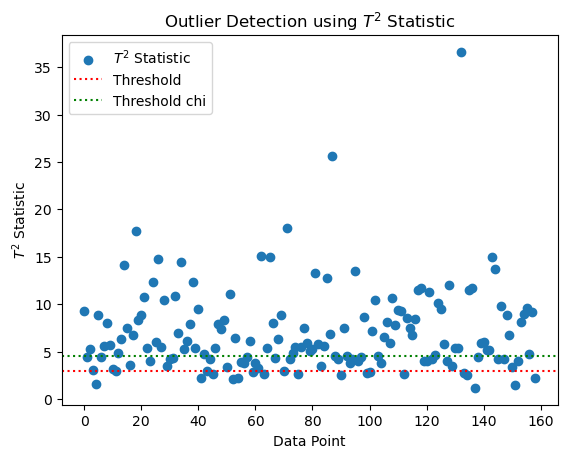

In [36]:
# Create a scatter plot of the T^2 statistic values
plt.scatter(range(len(t_squared_values_train_scale)), t_squared_values_train_scale, label='$T^2$ Statistic')

# Plot the threshold as a dotted line
plt.axhline(y=threshold_scale, linestyle='dotted', color='red', label='Threshold')

plt.axhline(y=threshold_chi_scale, linestyle='dotted', color='green', label='Threshold chi')

# Set the y-axis limits to ensure both lines are visible
#plt.ylim(min(threshold, threshold_chi) - 1, max(threshold, threshold_chi) + 1)


# Add labels and title to the plot
plt.xlabel('Data Point')
plt.ylabel('$T^2$ Statistic')
plt.title('Outlier Detection using $T^2$ Statistic')

# Add a legend
plt.legend()

# Show the plot
plt.show()

### Fault